# Ensembles, Random Forest
**Author**: Maria Tikhonova



In [1]:
%matplotlib inline

import os
import tempfile
import warnings

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns
from IPython.display import Image
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz

warnings.filterwarnings("ignore")


# Increase viewable area of Pandas tables, numpy arrays, plots
pd.set_option(
    "display.max_rows",
    15,
    "display.max_columns",
    500,
    "display.max_colwidth",
    1,
    "display.precision",
    2,
)
np.set_printoptions(linewidth=10000, precision=4, edgeitems=20, suppress=True)
sns.set()
plt.rcParams["figure.figsize"] = [16, 6]

# 1. Bias-Variance Decomposition

Рассмотрим задачу регрессией с MSE ошибкой. Предположим, что исходная зависимость выражается следующим образом:
$$ 
y(x) = f(x) + \epsilon 
$$ 

где $ \epsilon $ гауссовский шум, $\epsilon \sim \mathcal{N}(0,\sigma^2) $. 

Обозначим предсказания регрессионной модели как $ a(x) = \hat{y} $. 
Тогда для математического ожидания ошибки имеем следующее соотношение:

\begin{equation}
\begin{split}
Error & = \mathbb{E}_{X,Y,\epsilon}\left[(a(x) - y(x))^2\right] = \\
      & = \mathbb{E}_{X,Y}\left[(a(x) - \mathbb{E}_{X,Y}[a(x)])^2\right]  + \left(\mathbb{E}_{X,Y}\left[a(x)\right] - f(x)\right)^2 +  \sigma^2 = \\ & = \text{Variance} + \text{Bias}^2  + \text{Noise}
\end{split}
\end{equation}

Компоненты ошибки могут быть интерпретированы как:
* $\text{Variance}$ (Разброс) - чувствительность модели к данным. Высокая дисперсия обычно означает, что модель переобучилась.
* $\text{Bias}$ (Смещение) - отвечает за точность модели. Высокое смещение обычно означает, что модель недообучилась (underfitted).
* $\text{Noise}$ (Шум) - шум в данных (can't be helped).

## Пример

Для примера рассмотрим задачу регрессии и модель kNN.

### Одна модель

In [2]:
# Define target function for regression
def f(x):
    return np.sin(x)

Сгенерируем train и test.

In [3]:
# Define noise level
sigma = 0.2

# Generate train sample
X_train = np.random.random(size=5) * 2 * np.pi
y_train = f(X_train) + np.random.normal(loc=0.0, scale=sigma, size=len(X_train))

# Generate test smaple
X_test = np.linspace(0, 2 * np.pi, 1000)
y_test = f(X_test) + np.random.normal(loc=0.0, scale=sigma, size=len(X_test))

In [4]:
X_train

array([5.1125, 3.1201, 0.7422, 0.9623, 0.7509])

Обучим регрессионную модель.

In [5]:
from sklearn.neighbors import KNeighborsRegressor

# Create a model
reg = KNeighborsRegressor(n_neighbors=1)

# Fit the model
reg.fit(X_train.reshape(-1, 1), y_train)

KNeighborsRegressor(n_neighbors=1)

Сделаем предсказания для тестового сета.

In [6]:
from sklearn.metrics import mean_squared_error

# Make predictions
y_test_predict = reg.predict(X_test.reshape(-1, 1))

Визуализируем результат.

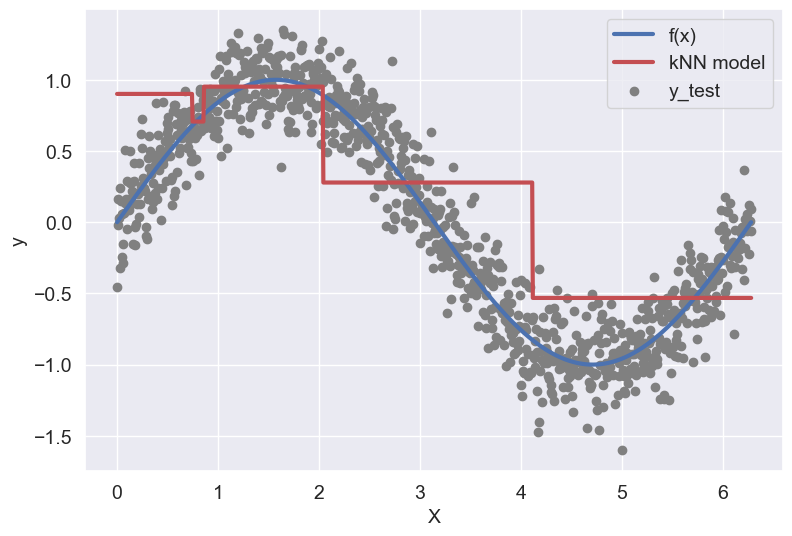

In [7]:
plt.figure(figsize=(9, 6))

plt.plot(X_test, f(X_test), label="f(x)", color="b", linewidth=3)
plt.plot(X_test, y_test_predict, label="kNN model", color="r", linewidth=3)
plt.scatter(X_test, y_test, label="y_test", color="0.5")

plt.xticks(size=14)
plt.xlabel("X", size=14)
plt.yticks(size=14)
plt.ylabel("y", size=14)
plt.legend(loc="best", fontsize=14)
plt.grid(b=1)
plt.show()

Визуализируем ошибку модели.

In [8]:
errors = (y_test_predict - y_test) ** 2

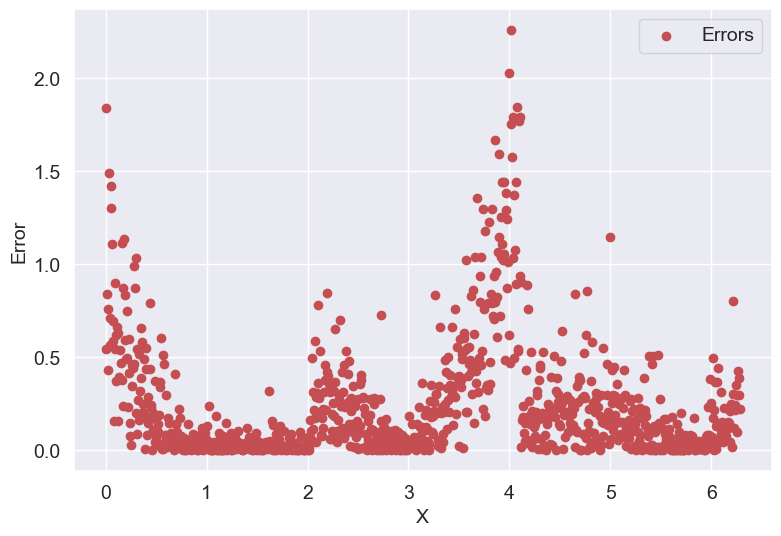

In [9]:
plt.figure(figsize=(9, 6))

plt.scatter(X_test, errors, label="Errors", color="r")

plt.xticks(size=14)
plt.xlabel("X", size=14)
plt.yticks(size=14)
plt.ylabel("Error", size=14)
plt.legend(loc="best", fontsize=14)
plt.grid(b=1)
plt.show()

## Несколько моделей

Обучим несколько моделей на рандомных обучающих сэмплах.

In [10]:
# Define noise level
sigma = 0.2

# Generate train sample
X_train = np.random.random(size=5) * 2 * np.pi
y_train = f(X_train) + np.random.normal(loc=0.0, scale=sigma, size=len(X_train))

# Generate test smaple
X_test = np.linspace(0, 2 * np.pi, 1000)
y_test = f(X_test) + np.random.normal(loc=0.0, scale=sigma, size=len(X_test))

In [11]:
N_iter = 1000
predictions = []
errors = []

for i in range(N_iter):

    # Generate random train sample
    X_train = np.random.random(size=5) * 2 * np.pi
    y_train = f(X_train) + np.random.normal(loc=0.0, scale=sigma, size=len(X_train))

    # Create a model
    reg = KNeighborsRegressor(n_neighbors=1)

    # Fit the model
    reg.fit(X_train.reshape(-1, 1), y_train)

    # Make predictions
    y_test_predict = reg.predict(X_test.reshape(-1, 1))

    # Save predictions
    predictions.append(y_test_predict)

    # Generate random test y
    y_test_iter = f(X_test) + np.random.normal(loc=0.0, scale=sigma, size=len(X_test))

    # Calculate errors
    errors_iter = (y_test_predict - y_test_iter) ** 2

    # Save errors
    errors.append(errors_iter)

predictions = np.array(predictions)
errors = np.array(errors)

Оценим матожидание предсказаний.

In [12]:
y_test_predict_mean = predictions.mean(axis=0)

Визуализируем модели.

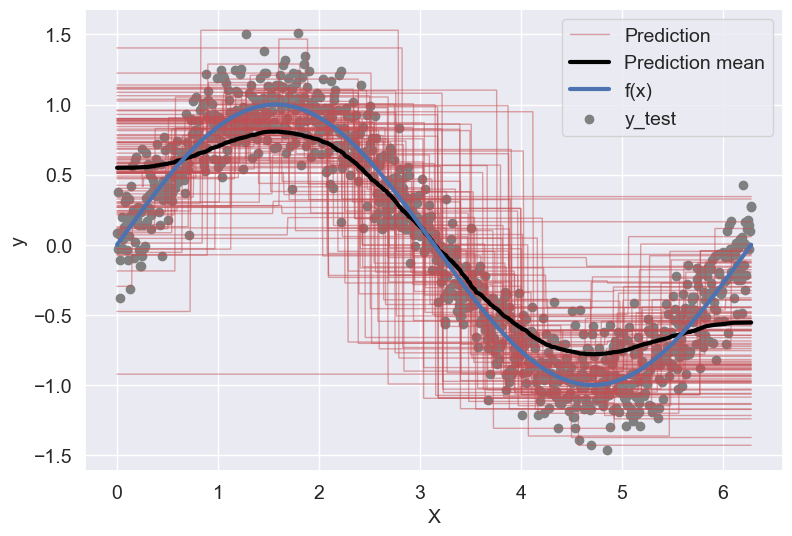

In [13]:
plt.figure(figsize=(9, 6))

for y_test_predict in predictions[:100]:
    plt.plot(X_test, y_test_predict, color="r", linewidth=1, alpha=0.5)

plt.plot(X_test, predictions[0], label="Prediction", color="r", linewidth=1, alpha=0.5)
plt.plot(X_test, y_test_predict_mean, label="Prediction mean", color="0", linewidth=3)
plt.plot(X_test, f(X_test), label="f(x)", color="b", linewidth=3)
plt.scatter(X_test, y_test, label="y_test", color="0.5")

plt.xticks(size=14)
plt.xlabel("X", size=14)
plt.yticks(size=14)
plt.ylabel("y", size=14)
plt.legend(loc="best", fontsize=14)
plt.grid(b=1)
plt.show()

### Разложение

\begin{equation}
\begin{split}
Error & = \mathbb{E}_{X,Y,\epsilon}\left[(a(x) - y(x))^2\right] = \\
      & = \mathbb{E}_{X,Y}\left[(a(x) - \mathbb{E}_{X,Y}[a(x)])^2\right]  + \left(\mathbb{E}_{X,Y}\left[a(x)\right] - f(x)\right)^2 +  \sigma^2 = \\ & = \text{Variance} + \text{Bias}^2  + \text{Noise}
\end{split}
\end{equation}

In [14]:
# Calculate expected errors
error = errors.mean(axis=0)

# Calculate varince of the model predictions
variance = predictions.std(axis=0) ** 2

# Calculate the model's bias
bias2 = (y_test_predict_mean - f(X_test)) ** 2

# Calculate the noise variance
noise = sigma**2

composition = variance + bias2 + noise

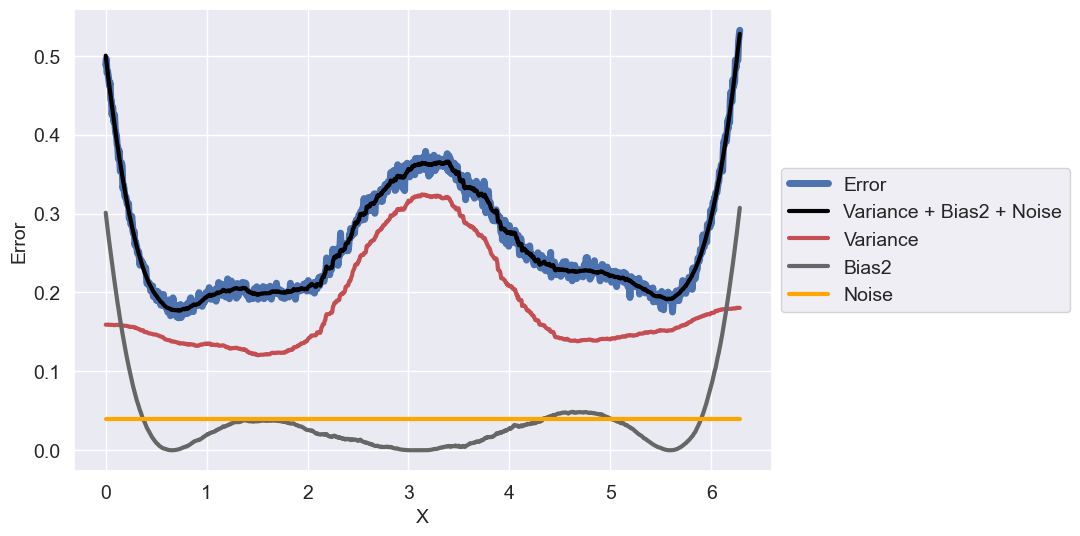

In [15]:
plt.figure(figsize=(9, 6))

plt.plot(X_test, error, label="Error", color="b", linewidth=5)
plt.plot(X_test, composition, label="Variance + Bias2 + Noise", color="0", linewidth=3)
plt.plot(X_test, variance, label="Variance", color="r", linewidth=3)
plt.plot(X_test, bias2, label="Bias2", color="0.4", linewidth=3)
plt.plot(X_test, [noise] * len(X_test), label="Noise", color="orange", linewidth=3)

plt.xticks(size=14)
plt.xlabel("X", size=14)
plt.yticks(size=14)
plt.ylabel("Error", size=14)
plt.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(b=1)
plt.show()

## Bonus part on theory
**Attention!**  Достаточно сложный теоретический [материал](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/seminars/sem08-bvd.pdf) по bias-variance decomposition.



# 2. Ансамбли

### Data  - Titanic data set

Сегодня будем работать с данными о пассажирах Титаника (Titatic dataset).

In [16]:
# data = pd.read_csv('titanic.csv')
data = pd.read_csv("https://grantmlong.com/data/titanic.csv")
cols_2_drop = ["PassengerId", "Ticket", "Cabin", "Name"]
data = data.drop(cols_2_drop, axis=1)
data.loc[:, "Age"] = data.Age.fillna(-999)

data = data.dropna()
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.25,S
1,1,1,female,38.0,1,0,71.28,C
2,1,3,female,26.0,0,0,7.92,S
3,1,1,female,35.0,1,0,53.10,S
4,0,3,male,35.0,0,0,8.05,S


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


Пропусков в данных нет, но есть 2 категориальных признака (`Sex`,`Embarked`). Закодируем их с помощью `OrdinalEncoder`.

In [18]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
data[["Sex", "Embarked"]] = enc.fit_transform(data[["Sex", "Embarked"]])
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1.0,22.0,1,0,7.25,2.0
1,1,1,0.0,38.0,1,0,71.28,0.0
2,1,3,0.0,26.0,0,0,7.92,2.0
3,1,1,0.0,35.0,1,0,53.10,2.0
4,0,3,1.0,35.0,0,0,8.05,2.0


In [19]:
X = data.drop("Survived", axis=1)
Y = data["Survived"]
# Train test split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=2)
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

((711, 7), (178, 7), (711,), (178,))

## Recap: высокий разброс решающих деревьев

Деревья решений обладают **высоким разбросом (high variance)**. Небольшие колебания в данных могут привести к сильным измениниям в получившихся обученных деревьях. 

In [20]:
def plot_tree(model, X):
    fname = tempfile.mkstemp(suffix='.png', prefix='ensembles_')[1]
    dot_data = export_graphviz(
        model, filled=True, rounded=True, feature_names=X.columns, out_file=None
    )
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.write_png(fname)
    img = plt.imread(fname)
    plt.imshow(img)

In [21]:
# Random state affects the order at which predictors are considered. At each split the predictors are randomly permuted
tree1 = DecisionTreeClassifier(random_state=0, max_depth=3)
tree1.fit(train_X, train_Y)
tree1_r2 = r2_score(tree1.predict(test_X), test_Y)
tree1_accuracy = accuracy_score(tree1.predict(test_X), test_Y)
print(f"Accuracy for the first tree: {tree1_accuracy:.4f}")

train_X_2, test_X_2, train_Y_2, test_Y_2 = train_test_split(
    X, Y, test_size=0.2, random_state=7
)

tree2 = DecisionTreeClassifier(random_state=0, max_depth=3)
tree2.fit(train_X_2, train_Y_2)

tree2_accuracy = accuracy_score(tree2.predict(test_X_2), test_Y_2)

print(f"Accuracy for the second tree: {tree2_accuracy:.4f}")

Accuracy for the first tree: 0.7753
Accuracy for the second tree: 0.7978


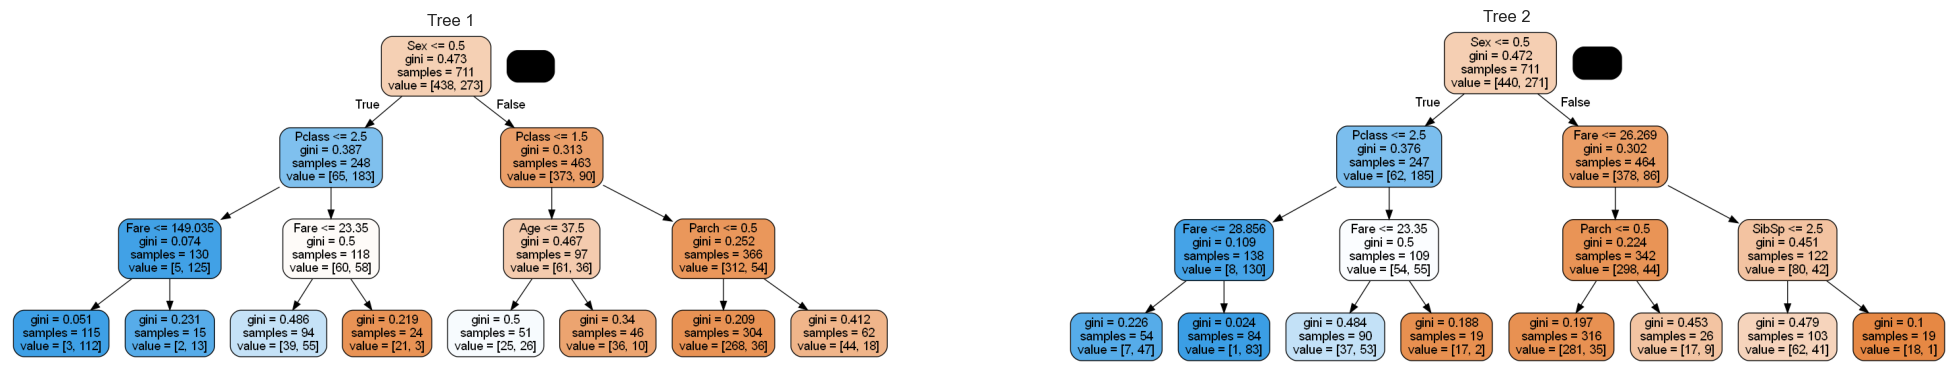

In [22]:
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plot_tree(tree1, train_X)
plt.axis("off")
plt.title(f"Tree 1")
plt.subplot(1, 2, 2)
plot_tree(tree2, train_X_2)
plt.axis("off")
plt.title(f"Tree 2")
plt.show()

Мы отправили в тест лишь 20% данных, а деревья получились очень разными! 

И при увеличении глубины дерева становится только хуже.

## Bagging
Вместо того, чтобы обучить одно дерево решений, обучим ансамбль по следующему алгоритму:

1. Сгенерируем $B$ бутсрэп выборок (сэмплирование с возвращением, помните?) из обучающего набора данных.
2. Обучим $B$ решающих деревьев $f_1, f_2, \dots, f_B$ на каждой из бутсреп подвыборок.
3. В качестве предсказания на тестовых данных возьмем среднее предсказание алгорима $\hat{y} = 1/B \sum_{i=0}^{B} f_i(x)$ (для задачи классификации возьмем наиболее популярный класс).


In [23]:
train_X, test_X, train_Y, test_Y = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [24]:
# BaggingRegressor can be used with any model, not only decision trees

model = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3), n_jobs=-1, n_estimators=100
)
model.fit(train_X, train_Y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                  n_estimators=100, n_jobs=-1)

In [25]:
print(
    f"Bagged trees accuracy score {accuracy_score(model.predict(test_X), test_Y):.4f}"
)

Bagged trees accuracy score 0.8090


Можем посмотреть на отдельные деревья.

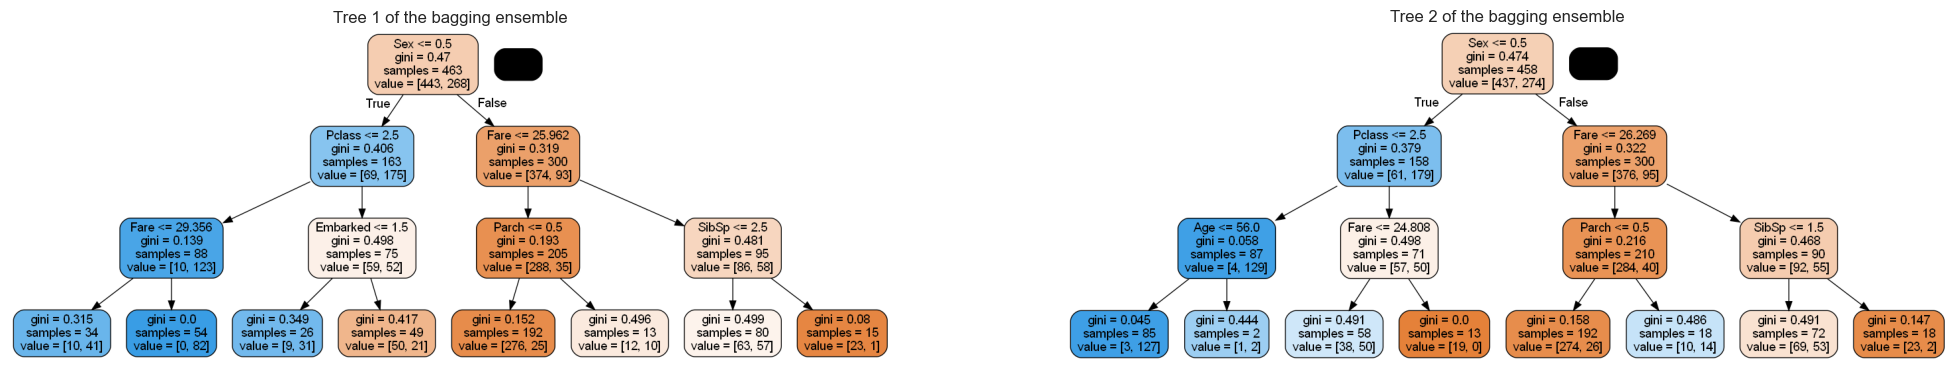

In [26]:
tree1, tree2 = model.estimators_[0], model.estimators_[1]

plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plot_tree(tree1, train_X)
plt.axis("off")
plt.title(f"Tree 1 of the bagging ensemble")
plt.subplot(1, 2, 2)
plot_tree(tree2, train_X)
plt.axis("off")
plt.title(f"Tree 2 of the bagging ensemble")
plt.show()

Процесс обучения бэггинг ансамбля позволяет оценивать тестовую ошибку без кросс-валидации. Вспомним, что каждое дерево обучается на помножестве train'овых данных. 

Для каждого примера $x_i$ сделаем предсказания с использованием тех деревьев, которые не использовали $x_i$ при обучении. Затем усредним предсказания и посчитаем ошибку. Получим робастную оценку тестовой ошибки. 

In [27]:
model = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=None),
    n_jobs=-1,
    n_estimators=20,
    oob_score=True,
)
model.fit(train_X, train_Y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=20,
                  n_jobs=-1, oob_score=True)

In [28]:
print(f"Test score estimate using Out-of-bag score {model.oob_score_:.4f}")
print(
    f'Test score estimate using Cross-Validation {cross_val_score(model, train_X, train_Y, scoring="accuracy").mean():.4f}'
)
print(f"Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}")

Test score estimate using Out-of-bag score 0.8200
Test score estimate using Cross-Validation 0.8059
Actual test score: 0.7809


## Random Forests
Деревья в бэггинг ансамблях зачастую сильно **коррелируют** между собой. Они очень похожи, так как обучаются на похожих выборках. Когда мы агрегируем предсказания похожих деревьев, мы не так сильно уменьшаем разброс (variance), как нам бы хотелось.

Как уменьшить корреляцию деревьев?

**Solution: Random Forest!** Построим ансамбль деревьев определенным образом. Каждый раз, когда будем выбирать сплит при обучении, будем перебирать только $m$ случайно выбранных признаков из $p$, при этом $m < p$.

In [29]:
RandomForestClassifier?

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.


In [30]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=3, oob_score=True)
model.fit(train_X, train_Y)

RandomForestClassifier(max_depth=3, n_jobs=-1, oob_score=True)

In [31]:
print(f"Test score estimate using Out-of-bag score {model.oob_score_:.4f}")
print(f"Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}")

Test score estimate using Out-of-bag score 0.7961
Actual test score: 0.8090


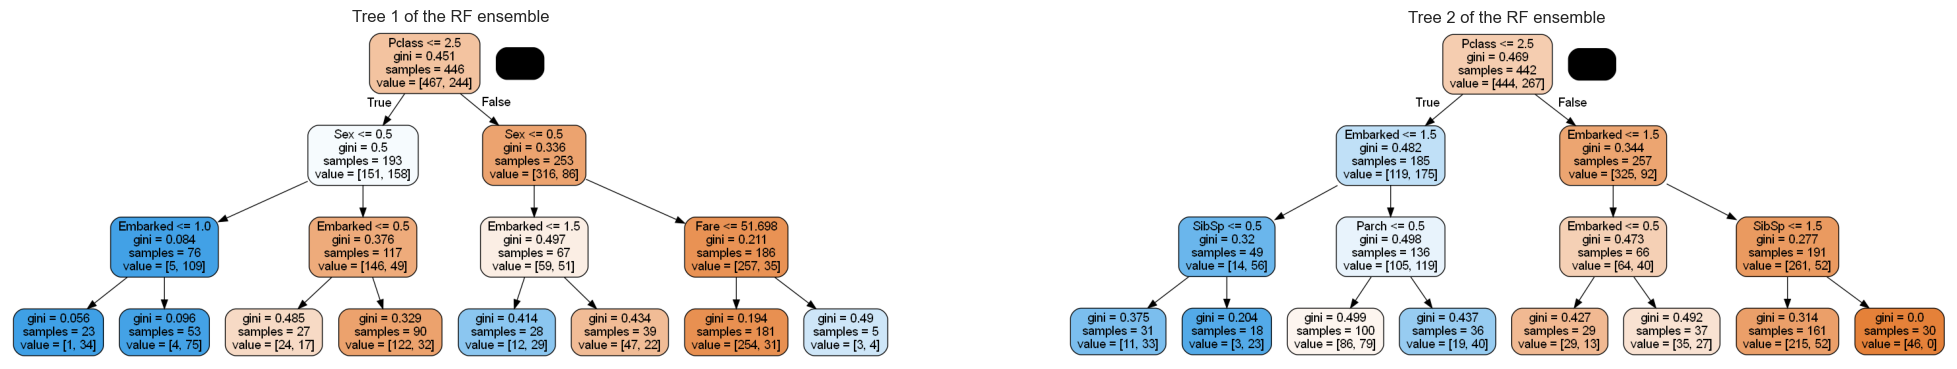

In [32]:
tree1, tree2 = model.estimators_[3], model.estimators_[0]

plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plot_tree(tree1, train_X)
plt.axis("off")
plt.title(f"Tree 1 of the RF ensemble")
plt.subplot(1, 2, 2)
plot_tree(tree2, train_X)
plt.axis("off")
plt.title(f"Tree 2 of the RF ensemble")
plt.show()

In [33]:
# Now lets try realistic max_depth
model = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, max_depth=None, oob_score=True
)
model.fit(train_X, train_Y)
print(f"Test score estimate using Out-of-bag score {model.oob_score_:.4f}")
print(f"Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}")

Test score estimate using Out-of-bag score 0.8115
Actual test score: 0.7472


## Важность признаков (feature importance)

Для каждого дерева, для признака можно посчитать прирост информации (information gain), полученный при разбиении по этому признаку. Это и есть мера важности признака.



In [34]:
feature_importances = zip(train_X.columns, model.feature_importances_)
list(feature_importances)

[('Pclass', 0.0828773212646739),
 ('Sex', 0.25038740202169885),
 ('Age', 0.24074360368378828),
 ('SibSp', 0.054288363469137846),
 ('Parch', 0.04889386155177527),
 ('Fare', 0.284366645582507),
 ('Embarked', 0.03844280242641894)]

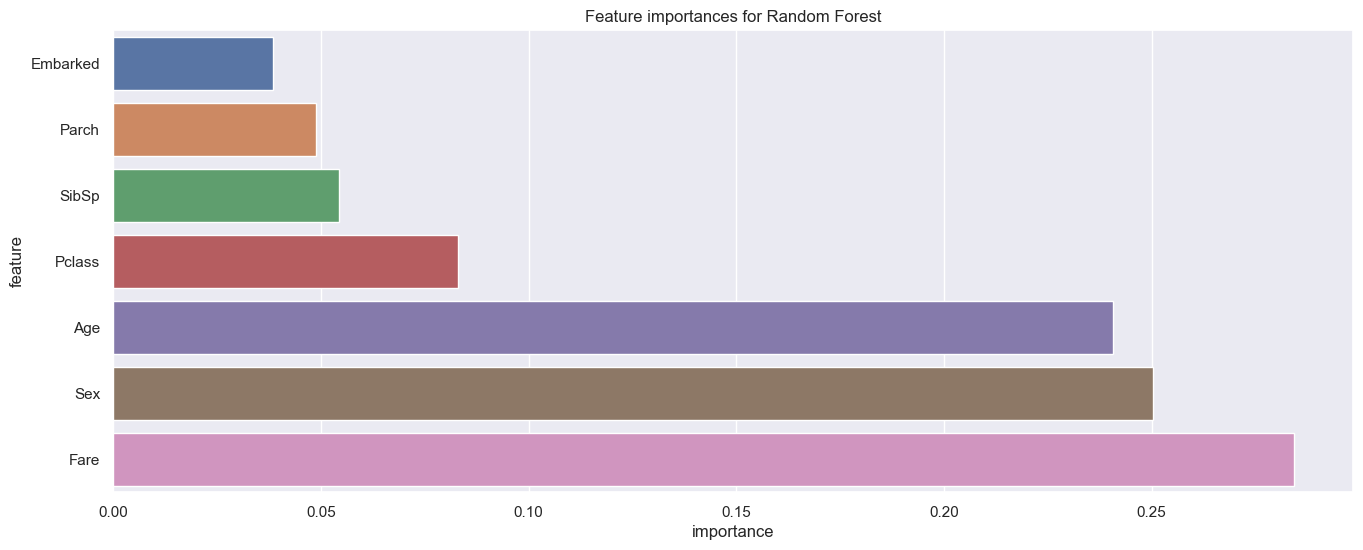

In [35]:
feature_importances = zip(train_X.columns, model.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1])
feature_importances = pd.DataFrame(
    feature_importances, columns=["feature", "importance"]
)

plt.title("Feature importances for Random Forest")
sns.barplot(x="importance", y="feature", data=feature_importances)
plt.show()

## Tuning

Основные фичи, которые можно тюнить:
* `n_estimators` - число деревьев,
* `max_samples` - число сэмплов в бутсреп выборке,
* `max_features` - число признаков, которое рассматривается при разбиении,
* `max_depth` - максимальная глубина дерева.


Больше информации можно найти [тут](https://dyakonov.org/2016/11/14/%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B9-%D0%BB%D0%B5%D1%81-random-forest/).

In [36]:
parameters = {
    "n_estimators": [5, 10, 50, 100, 500],
    "max_features": [None, 3],
    "max_depth": [None, 3, 5, 10],
}

model = RandomForestClassifier()
clf = GridSearchCV(model, parameters, scoring="accuracy")

clf.fit(train_X, train_Y)
pred = clf.predict(test_X)

print("Best parameters: ", clf.best_params_)

Best parameters:  {'max_depth': 10, 'max_features': None, 'n_estimators': 500}


Кроме регрессии и классификации random forest используется для:
* Кластеризации 
* Детекции аномалий
* Отбора признаков

и не только!

# Blending 
Блендинг обучает "мета-алгоритм", используя предсказания алгоритмов первого уровня в качестве признаков. Давайте посмотрим на простой пример блендига с Random Forest в качестве алгоритмов первого уровня и "мета-алгоритмом" - линейной регрессией.

## Данные
Рассмотрим алгоритм стекинга на примере задачи предсказания цен на жилье в Бостоне. Данный датасет имплементирован в `sklearn.datasets`:

````
from sklearn.datasets import load_boston
data = load_boston()
````

Описание из документации:
The Boston housing prices dataset has an ethical problem. You can refer to
the documentation of this function for further details.

При обучение блендинга, нам понадобится не только обучающий и тестовый набор данных, но и валидационный датасет, на котором мы будем подбирать веса мета-алгоритма.



In [37]:
import pickle

from sklearn.datasets import load_boston

data = load_boston()
# data = pickle.load(open('boston_data.pkl', 'rb'))
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=10
)
print(X_train.shape, X_val.shape, X_test.shape, len(y_train), len(y_val), len(y_test))


def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))


X.head()

(323, 13) (81, 13) (102, 13) 323 81 102


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,6.32e-03,18.0,2.31,0.0,0.54,6.58,65.2,4.09,1.0,296.0,15.3,396.90,4.98
1,2.73e-02,0.0,7.07,0.0,0.47,6.42,78.9,4.97,2.0,242.0,17.8,396.90,9.14
2,2.73e-02,0.0,7.07,0.0,0.47,7.18,61.1,4.97,2.0,242.0,17.8,392.83,4.03
3,3.24e-02,0.0,2.18,0.0,0.46,7.00,45.8,6.06,3.0,222.0,18.7,394.63,2.94
4,6.91e-02,0.0,2.18,0.0,0.46,7.15,54.2,6.06,3.0,222.0,18.7,396.90,5.33


Так как один из обучаемых алгоритмов - линейная регрессия, то признаки необходимо нормализовать. Для этого воспользуемся Standard Scaler. 

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Обучим Random Forest.

In [39]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=2)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_train_pred_rf = rf.predict(X_train_scaled)
y_val_pred_rf = rf.predict(X_val_scaled)

print("Train RMSE RF = %.4f" % rmse(y_train, y_train_pred_rf))
print("Val RMSE RF = %.4f" % rmse(y_val, y_val_pred_rf))
print("Test RMSE RF = %.4f" % rmse(y_test, y_pred_rf))

Train RMSE RF = 1.3106
Val RMSE RF = 3.0219
Test RMSE RF = 4.0527


Теперь обучим линейную регрессию.

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_val_pred_lr = lr.predict(X_val_scaled)
y_train_pred_lr = lr.predict(X_train_scaled)

print("Train RMSE LR = %.4f" % rmse(y_train, y_train_pred_lr))
print("Val RMSE LR = %.4f" % rmse(y_val, y_val_pred_lr))
print("Test RMSE LR = %.4f" % rmse(y_test, y_pred_lr))

Train RMSE LR = 4.4214
Val RMSE LR = 4.3965
Test RMSE LR = 5.9172


Для простоты предположим, что мета-алгритм $a(x)$ - это линейная комбинация алгоритмов первого уровня:
$$
    a(x)
    =
    \sum_{n = 1}^{N}
    w_n b_n(x),
$$
где веса суммируются в 1:
 $$\sum_{n} w_n =1$$

In [41]:
def select_weights(y_true, y_pred_1, y_pred_2):
    grid = np.linspace(0, 1, 1000)
    metric = []
    for w_0 in grid:
        w_1 = 1 - w_0
        y_a = w_0 * y_pred_1 + w_1 * y_pred_2
        metric.append([rmse(y_true, y_a), w_0, w_1])
    return metric

Обратите внимание, подбор весов необходимо делать на отдельно отложенном наборе данных (валидационном множестве).

**Вопрос:** почему некорретно это делать на обучающих или тестовых данных?

In [42]:
rmse_blending_val, w_0, w_1 = min(
    select_weights(y_val, y_val_pred_rf, y_val_pred_lr), key=lambda x: x[0]
)
print("Weight for RF: ", round(w_0, 3))
print("Weight for LR: ", round(w_1, 3))

Weight for RF:  0.889
Weight for LR:  0.111


Подобрав веса, сделаем взвешенное предсказание стекинга для теста.

In [43]:
print(
    "Stacking test error: ", round(rmse(y_test, y_pred_rf * w_0 + y_pred_lr * w_1), 3)
)

Stacking test error:  4.04


**Уcпех!**
С помощью блендинга нам удалось достичь лучшего качества, чем каждый отдельный алгоритм.